<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE2] - First VAE, using a subclass model (MNIST dataset)
<!-- DESC --> Construction and training of a VAE, using model subclass, with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a still more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.models    import VAE
from modules.layers    import SamplingLayer
from modules.callbacks import ImagesCallback, BestModelCallback
from modules.datagen   import MNIST

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/VAE2.005'
datasets_dir = pwk.init('VAE2', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE2_done_0001


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.22
Notebook id          : VAE2
Run time             : Monday 22 March 2021, 14:41:12
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE2_done_0001
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE2_done_0001/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
`scale` : With scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !\
`latent_dim` : 2 dimensions is small, but usefull to draw !


`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,6e-4\] gives good results here.


In [2]:
latent_dim    = 2
loss_weights  = [1,6e-4]

scale         = 1
seed          = 123

batch_size    = 64
epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

latent_dim           : 2
loss_weights         : [1, 0.0001]
scale                : 1
seed                 : 123
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

Seeded (123)


Dataset loaded.
Concatenated.
Shuffled.
rescaled (1).
Normalized.
Reshaped.
splited (1).


x_train shape is  :  (70000, 28, 28, 1)
x_test  shape is  :  (0, 28, 28, 1)
y_train shape is  :  (70000,)
y_test  shape is  :  (0,)
Blake2b digest is :  0c903710d4d28b01c174


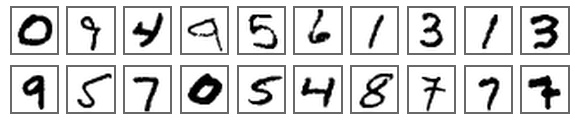

In [4]:
x_data, y_data, _,_ = MNIST.get_data(seed=seed, scale=scale, train_prop=1 )

pwk.plot_images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

## Step 4 - Build model
In this example, we will use a **custom model**.
For this, we will use :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VAE`, a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()

#### VAE
`VAE` is a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

In [7]:
vae = VAE(encoder, decoder, loss_weights)

vae.compile(optimizer='adam')

Fidle VAE is ready :-)  loss_weights=[1, 0.0001]


## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [8]:
callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
pwk.chrono_start()

history = vae.fit(x_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:08:45 - loss: 0.6929 - r_loss: 0.6929 - kl_loss: 5.8964e-08

  12/1094 [..............................] - ETA: 4s - loss: 0.6537 - r_loss: 0.6512 - kl_loss: 0.0025         

  24/1094 [..............................] - ETA: 4s - loss: 0.5913 - r_loss: 0.5900 - kl_loss: 0.0013

  36/1094 [..............................] - ETA: 4s - loss: 0.5337 - r_loss: 0.5329 - kl_loss: 8.4458e-04

  48/1094 [>.............................] - ETA: 4s - loss: 0.4875 - r_loss: 0.4868 - kl_loss: 6.3375e-04

  60/1094 [>.............................] - ETA: 4s - loss: 0.4498 - r_loss: 0.4493 - kl_loss: 5.0717e-04

  72/1094 [>.............................] - ETA: 4s - loss: 0.4200 - r_loss: 0.4196 - kl_loss: 4.2280e-04

  84/1094 [=>............................] - ETA: 4s - loss: 0.3988 - r_loss: 0.3984 - kl_loss: 3.6254e-04

  96/1094 [=>............................] - ETA: 4s - loss: 0.3824 - r_loss: 0.3821 - kl_loss: 3.1740e-04

 108/1094 [=>............................] - ETA: 4s - loss: 0.3696 - r_loss: 0.3693 - kl_loss: 2.8250e-04

 120/1094 [==>...........................] - ETA: 4s - loss: 0.3589 - r_loss: 0.3587 - kl_loss: 2.5574e-04

 132/1094 [==>...........................] - ETA: 4s - loss: 0.3503 - r_loss: 0.3501 - kl_loss: 2.4312e-04

 144/1094 [==>...........................] - ETA: 4s - loss: 0.3427 - r_loss: 0.3425 - kl_loss: 2.5456e-04

 156/1094 [===>..........................] - ETA: 4s - loss: 0.3358 - r_loss: 0.3356 - kl_loss: 2.7225e-04

 168/1094 [===>..........................] - ETA: 4s - loss: 0.3296 - r_loss: 0.3293 - kl_loss: 2.8914e-04

 180/1094 [===>..........................] - ETA: 4s - loss: 0.3242 - r_loss: 0.3239 - kl_loss: 3.0056e-04

 192/1094 [====>.........................] - ETA: 3s - loss: 0.3195 - r_loss: 0.3192 - kl_loss: 3.0758e-04

 204/1094 [====>.........................] - ETA: 3s - loss: 0.3153 - r_loss: 0.3150 - kl_loss: 3.0839e-04

 216/1094 [====>.........................] - ETA: 3s - loss: 0.3112 - r_loss: 0.3109 - kl_loss: 3.1612e-04

 228/1094 [=====>........................] - ETA: 3s - loss: 0.3077 - r_loss: 0.3074 - kl_loss: 3.1690e-04

 240/1094 [=====>........................] - ETA: 3s - loss: 0.3043 - r_loss: 0.3040 - kl_loss: 3.1640e-04

 252/1094 [=====>........................] - ETA: 3s - loss: 0.3011 - r_loss: 0.3008 - kl_loss: 3.1784e-04

 264/1094 [======>.......................] - ETA: 3s - loss: 0.2983 - r_loss: 0.2980 - kl_loss: 3.1879e-04

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2957 - r_loss: 0.2954 - kl_loss: 3.1978e-04

 288/1094 [======>.......................] - ETA: 3s - loss: 0.2932 - r_loss: 0.2928 - kl_loss: 3.2269e-04

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2908 - r_loss: 0.2904 - kl_loss: 3.2582e-04

 312/1094 [=======>......................] - ETA: 3s - loss: 0.2887 - r_loss: 0.2884 - kl_loss: 3.2734e-04

 324/1094 [=======>......................] - ETA: 3s - loss: 0.2868 - r_loss: 0.2865 - kl_loss: 3.3135e-04

 336/1094 [========>.....................] - ETA: 3s - loss: 0.2848 - r_loss: 0.2845 - kl_loss: 3.3781e-04

 348/1094 [========>.....................] - ETA: 3s - loss: 0.2830 - r_loss: 0.2826 - kl_loss: 3.4578e-04

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2813 - r_loss: 0.2809 - kl_loss: 3.5574e-04

 372/1094 [=========>....................] - ETA: 3s - loss: 0.2794 - r_loss: 0.2791 - kl_loss: 3.6639e-04

 384/1094 [=========>....................] - ETA: 3s - loss: 0.2775 - r_loss: 0.2771 - kl_loss: 3.7600e-04

 396/1094 [=========>....................] - ETA: 3s - loss: 0.2757 - r_loss: 0.2753 - kl_loss: 3.8682e-04

 408/1094 [==========>...................] - ETA: 3s - loss: 0.2741 - r_loss: 0.2737 - kl_loss: 3.9724e-04

 420/1094 [==========>...................] - ETA: 2s - loss: 0.2725 - r_loss: 0.2721 - kl_loss: 4.0615e-04

 432/1094 [==========>...................] - ETA: 2s - loss: 0.2710 - r_loss: 0.2706 - kl_loss: 4.1380e-04

 444/1094 [===========>..................] - ETA: 2s - loss: 0.2695 - r_loss: 0.2690 - kl_loss: 4.2013e-04

 456/1094 [===========>..................] - ETA: 2s - loss: 0.2680 - r_loss: 0.2675 - kl_loss: 4.2704e-04

 468/1094 [===========>..................] - ETA: 2s - loss: 0.2665 - r_loss: 0.2661 - kl_loss: 4.3382e-04

 480/1094 [============>.................] - ETA: 2s - loss: 0.2652 - r_loss: 0.2647 - kl_loss: 4.3981e-04

 492/1094 [============>.................] - ETA: 2s - loss: 0.2639 - r_loss: 0.2634 - kl_loss: 4.4534e-04

 504/1094 [============>.................] - ETA: 2s - loss: 0.2626 - r_loss: 0.2621 - kl_loss: 4.5122e-04

 516/1094 [=============>................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2609 - kl_loss: 4.5690e-04

 528/1094 [=============>................] - ETA: 2s - loss: 0.2602 - r_loss: 0.2597 - kl_loss: 4.6179e-04

 540/1094 [=============>................] - ETA: 2s - loss: 0.2590 - r_loss: 0.2585 - kl_loss: 4.6686e-04

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2579 - r_loss: 0.2574 - kl_loss: 4.7037e-04

 564/1094 [==============>...............] - ETA: 2s - loss: 0.2568 - r_loss: 0.2564 - kl_loss: 4.7328e-04

 576/1094 [==============>...............] - ETA: 2s - loss: 0.2558 - r_loss: 0.2553 - kl_loss: 4.7644e-04

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2548 - r_loss: 0.2543 - kl_loss: 4.8013e-04

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2538 - r_loss: 0.2533 - kl_loss: 4.8362e-04

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2529 - r_loss: 0.2524 - kl_loss: 4.8651e-04

 624/1094 [================>.............] - ETA: 2s - loss: 0.2520 - r_loss: 0.2515 - kl_loss: 4.8881e-04

 636/1094 [================>.............] - ETA: 2s - loss: 0.2511 - r_loss: 0.2506 - kl_loss: 4.9220e-04

 648/1094 [================>.............] - ETA: 1s - loss: 0.2502 - r_loss: 0.2497 - kl_loss: 4.9457e-04

 660/1094 [=================>............] - ETA: 1s - loss: 0.2494 - r_loss: 0.2489 - kl_loss: 4.9659e-04

 672/1094 [=================>............] - ETA: 1s - loss: 0.2486 - r_loss: 0.2481 - kl_loss: 4.9931e-04

 684/1094 [=================>............] - ETA: 1s - loss: 0.2479 - r_loss: 0.2474 - kl_loss: 5.0121e-04

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2472 - r_loss: 0.2467 - kl_loss: 5.0293e-04

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2464 - r_loss: 0.2459 - kl_loss: 5.0561e-04

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2457 - r_loss: 0.2452 - kl_loss: 5.0775e-04

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2450 - r_loss: 0.2445 - kl_loss: 5.1041e-04

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2443 - r_loss: 0.2438 - kl_loss: 5.1267e-04

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2437 - r_loss: 0.2432 - kl_loss: 5.1457e-04

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2431 - r_loss: 0.2426 - kl_loss: 5.1633e-04

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2424 - r_loss: 0.2419 - kl_loss: 5.1792e-04

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2417 - r_loss: 0.2412 - kl_loss: 5.1993e-04

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2412 - r_loss: 0.2407 - kl_loss: 5.2097e-04

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2406 - r_loss: 0.2401 - kl_loss: 5.2282e-04

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2401 - r_loss: 0.2395 - kl_loss: 5.2502e-04

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2395 - r_loss: 0.2390 - kl_loss: 5.2712e-04

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2390 - r_loss: 0.2384 - kl_loss: 5.2875e-04

 864/1094 [======================>.......] - ETA: 1s - loss: 0.2384 - r_loss: 0.2378 - kl_loss: 5.3065e-04

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2378 - r_loss: 0.2373 - kl_loss: 5.3218e-04

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2374 - r_loss: 0.2368 - kl_loss: 5.3340e-04

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2368 - r_loss: 0.2363 - kl_loss: 5.3514e-04

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2364 - r_loss: 0.2358 - kl_loss: 5.3710e-04

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2358 - r_loss: 0.2353 - kl_loss: 5.3942e-04

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2354 - r_loss: 0.2348 - kl_loss: 5.4095e-04

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2349 - r_loss: 0.2344 - kl_loss: 5.4274e-04

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2344 - r_loss: 0.2338 - kl_loss: 5.4413e-04

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2340 - r_loss: 0.2335 - kl_loss: 5.4498e-04

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2335 - r_loss: 0.2330 - kl_loss: 5.4625e-04

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2330 - r_loss: 0.2325 - kl_loss: 5.4740e-04

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2326 - r_loss: 0.2321 - kl_loss: 5.4828e-04

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2322 - r_loss: 0.2317 - kl_loss: 5.4890e-04

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2318 - r_loss: 0.2313 - kl_loss: 5.5000e-04

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2314 - r_loss: 0.2309 - kl_loss: 5.5092e-04

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2311 - r_loss: 0.2305 - kl_loss: 5.5157e-04

1068/1094 [============================>.] - ETA: 0s - loss: 0.2307 - r_loss: 0.2301 - kl_loss: 5.5218e-04

1080/1094 [============================>.] - ETA: 0s - loss: 0.2303 - r_loss: 0.2297 - kl_loss: 5.5344e-04

1092/1094 [============================>.] - ETA: 0s - loss: 0.2299 - r_loss: 0.2294 - kl_loss: 5.5493e-04

1094/1094 [==============================] - ETA: 0s - loss: 0.2299 - r_loss: 0.2293 - kl_loss: 5.5509e-04

1094/1094 [==============================] - 9s 4ms/step - loss: 0.2298 - r_loss: 0.2293 - kl_loss: 5.5523e-04


Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2040 - r_loss: 0.2034 - kl_loss: 5.9010e-04

  12/1094 [..............................] - ETA: 4s - loss: 0.1956 - r_loss: 0.1949 - kl_loss: 6.8461e-04

  24/1094 [..............................] - ETA: 4s - loss: 0.1963 - r_loss: 0.1957 - kl_loss: 6.4982e-04

  36/1094 [..............................] - ETA: 4s - loss: 0.1955 - r_loss: 0.1949 - kl_loss: 6.5780e-04

  48/1094 [>.............................] - ETA: 4s - loss: 0.1948 - r_loss: 0.1941 - kl_loss: 6.6255e-04

  60/1094 [>.............................] - ETA: 4s - loss: 0.1952 - r_loss: 0.1946 - kl_loss: 6.5825e-04

  72/1094 [>.............................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1951 - kl_loss: 6.5765e-04

  84/1094 [=>............................] - ETA: 4s - loss: 0.1962 - r_loss: 0.1956 - kl_loss: 6.5541e-04

  96/1094 [=>............................] - ETA: 4s - loss: 0.1961 - r_loss: 0.1954 - kl_loss: 6.4937e-04

 108/1094 [=>............................] - ETA: 4s - loss: 0.1961 - r_loss: 0.1954 - kl_loss: 6.4814e-04

 120/1094 [==>...........................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1951 - kl_loss: 6.4719e-04

 132/1094 [==>...........................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1950 - kl_loss: 6.4700e-04

 144/1094 [==>...........................] - ETA: 4s - loss: 0.1959 - r_loss: 0.1953 - kl_loss: 6.4680e-04

 156/1094 [===>..........................] - ETA: 4s - loss: 0.1956 - r_loss: 0.1949 - kl_loss: 6.4719e-04

 168/1094 [===>..........................] - ETA: 4s - loss: 0.1956 - r_loss: 0.1950 - kl_loss: 6.4910e-04

 180/1094 [===>..........................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1950 - kl_loss: 6.4938e-04

 192/1094 [====>.........................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1947 - kl_loss: 6.5169e-04

 204/1094 [====>.........................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1947 - kl_loss: 6.5083e-04

 216/1094 [====>.........................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1948 - kl_loss: 6.5115e-04

 228/1094 [=====>........................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1949 - kl_loss: 6.5102e-04

 240/1094 [=====>........................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1948 - kl_loss: 6.5232e-04

 252/1094 [=====>........................] - ETA: 3s - loss: 0.1956 - r_loss: 0.1950 - kl_loss: 6.5281e-04

 264/1094 [======>.......................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1949 - kl_loss: 6.5330e-04

 276/1094 [======>.......................] - ETA: 3s - loss: 0.1957 - r_loss: 0.1950 - kl_loss: 6.5187e-04

 288/1094 [======>.......................] - ETA: 3s - loss: 0.1957 - r_loss: 0.1950 - kl_loss: 6.5204e-04

 300/1094 [=======>......................] - ETA: 3s - loss: 0.1957 - r_loss: 0.1950 - kl_loss: 6.5284e-04

 312/1094 [=======>......................] - ETA: 3s - loss: 0.1956 - r_loss: 0.1949 - kl_loss: 6.5189e-04

 324/1094 [=======>......................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1949 - kl_loss: 6.5280e-04

 336/1094 [========>.....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1948 - kl_loss: 6.5311e-04

 348/1094 [========>.....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1948 - kl_loss: 6.5351e-04

 360/1094 [========>.....................] - ETA: 3s - loss: 0.1953 - r_loss: 0.1946 - kl_loss: 6.5418e-04

 372/1094 [=========>....................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1945 - kl_loss: 6.5379e-04

 384/1094 [=========>....................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1944 - kl_loss: 6.5378e-04

 396/1094 [=========>....................] - ETA: 3s - loss: 0.1950 - r_loss: 0.1944 - kl_loss: 6.5365e-04

 408/1094 [==========>...................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1943 - kl_loss: 6.5220e-04

 420/1094 [==========>...................] - ETA: 2s - loss: 0.1950 - r_loss: 0.1943 - kl_loss: 6.5211e-04

 432/1094 [==========>...................] - ETA: 2s - loss: 0.1949 - r_loss: 0.1943 - kl_loss: 6.5195e-04

 444/1094 [===========>..................] - ETA: 2s - loss: 0.1948 - r_loss: 0.1942 - kl_loss: 6.5187e-04

 456/1094 [===========>..................] - ETA: 2s - loss: 0.1948 - r_loss: 0.1941 - kl_loss: 6.5215e-04

 468/1094 [===========>..................] - ETA: 2s - loss: 0.1948 - r_loss: 0.1941 - kl_loss: 6.5201e-04

 480/1094 [============>.................] - ETA: 2s - loss: 0.1946 - r_loss: 0.1940 - kl_loss: 6.5266e-04

 492/1094 [============>.................] - ETA: 2s - loss: 0.1945 - r_loss: 0.1938 - kl_loss: 6.5332e-04

 504/1094 [============>.................] - ETA: 2s - loss: 0.1944 - r_loss: 0.1938 - kl_loss: 6.5284e-04

 516/1094 [=============>................] - ETA: 2s - loss: 0.1944 - r_loss: 0.1937 - kl_loss: 6.5278e-04

 528/1094 [=============>................] - ETA: 2s - loss: 0.1943 - r_loss: 0.1937 - kl_loss: 6.5320e-04

 540/1094 [=============>................] - ETA: 2s - loss: 0.1943 - r_loss: 0.1937 - kl_loss: 6.5295e-04

 552/1094 [==============>...............] - ETA: 2s - loss: 0.1942 - r_loss: 0.1936 - kl_loss: 6.5348e-04

 564/1094 [==============>...............] - ETA: 2s - loss: 0.1942 - r_loss: 0.1935 - kl_loss: 6.5323e-04

 576/1094 [==============>...............] - ETA: 2s - loss: 0.1941 - r_loss: 0.1935 - kl_loss: 6.5292e-04

 588/1094 [===============>..............] - ETA: 2s - loss: 0.1940 - r_loss: 0.1934 - kl_loss: 6.5314e-04

 600/1094 [===============>..............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1933 - kl_loss: 6.5315e-04

 612/1094 [===============>..............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1932 - kl_loss: 6.5360e-04

 624/1094 [================>.............] - ETA: 2s - loss: 0.1938 - r_loss: 0.1931 - kl_loss: 6.5356e-04

 636/1094 [================>.............] - ETA: 2s - loss: 0.1937 - r_loss: 0.1930 - kl_loss: 6.5456e-04

 648/1094 [================>.............] - ETA: 1s - loss: 0.1937 - r_loss: 0.1930 - kl_loss: 6.5505e-04

 660/1094 [=================>............] - ETA: 1s - loss: 0.1936 - r_loss: 0.1930 - kl_loss: 6.5503e-04

 672/1094 [=================>............] - ETA: 1s - loss: 0.1936 - r_loss: 0.1929 - kl_loss: 6.5538e-04

 684/1094 [=================>............] - ETA: 1s - loss: 0.1935 - r_loss: 0.1928 - kl_loss: 6.5557e-04

 696/1094 [==================>...........] - ETA: 1s - loss: 0.1935 - r_loss: 0.1929 - kl_loss: 6.5560e-04

 708/1094 [==================>...........] - ETA: 1s - loss: 0.1934 - r_loss: 0.1927 - kl_loss: 6.5599e-04

 720/1094 [==================>...........] - ETA: 1s - loss: 0.1934 - r_loss: 0.1928 - kl_loss: 6.5562e-04

 732/1094 [===================>..........] - ETA: 1s - loss: 0.1933 - r_loss: 0.1927 - kl_loss: 6.5638e-04

 744/1094 [===================>..........] - ETA: 1s - loss: 0.1932 - r_loss: 0.1925 - kl_loss: 6.5679e-04

 756/1094 [===================>..........] - ETA: 1s - loss: 0.1932 - r_loss: 0.1925 - kl_loss: 6.5751e-04

 768/1094 [====================>.........] - ETA: 1s - loss: 0.1932 - r_loss: 0.1925 - kl_loss: 6.5739e-04

 780/1094 [====================>.........] - ETA: 1s - loss: 0.1932 - r_loss: 0.1925 - kl_loss: 6.5705e-04

 792/1094 [====================>.........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1924 - kl_loss: 6.5729e-04

 804/1094 [=====================>........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1924 - kl_loss: 6.5730e-04

 816/1094 [=====================>........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1924 - kl_loss: 6.5749e-04

 828/1094 [=====================>........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1924 - kl_loss: 6.5747e-04

 840/1094 [======================>.......] - ETA: 1s - loss: 0.1930 - r_loss: 0.1924 - kl_loss: 6.5773e-04

 852/1094 [======================>.......] - ETA: 1s - loss: 0.1930 - r_loss: 0.1923 - kl_loss: 6.5733e-04

 864/1094 [======================>.......] - ETA: 1s - loss: 0.1930 - r_loss: 0.1923 - kl_loss: 6.5731e-04

 876/1094 [=======================>......] - ETA: 0s - loss: 0.1929 - r_loss: 0.1922 - kl_loss: 6.5731e-04

 888/1094 [=======================>......] - ETA: 0s - loss: 0.1929 - r_loss: 0.1922 - kl_loss: 6.5749e-04

 900/1094 [=======================>......] - ETA: 0s - loss: 0.1929 - r_loss: 0.1922 - kl_loss: 6.5790e-04

 912/1094 [========================>.....] - ETA: 0s - loss: 0.1928 - r_loss: 0.1922 - kl_loss: 6.5802e-04

 924/1094 [========================>.....] - ETA: 0s - loss: 0.1928 - r_loss: 0.1921 - kl_loss: 6.5786e-04

 936/1094 [========================>.....] - ETA: 0s - loss: 0.1928 - r_loss: 0.1921 - kl_loss: 6.5765e-04

 948/1094 [========================>.....] - ETA: 0s - loss: 0.1928 - r_loss: 0.1921 - kl_loss: 6.5781e-04

 960/1094 [=========================>....] - ETA: 0s - loss: 0.1927 - r_loss: 0.1921 - kl_loss: 6.5803e-04

 972/1094 [=========================>....] - ETA: 0s - loss: 0.1927 - r_loss: 0.1921 - kl_loss: 6.5825e-04

 984/1094 [=========================>....] - ETA: 0s - loss: 0.1926 - r_loss: 0.1920 - kl_loss: 6.5823e-04

 996/1094 [==========================>...] - ETA: 0s - loss: 0.1926 - r_loss: 0.1920 - kl_loss: 6.5841e-04

1008/1094 [==========================>...] - ETA: 0s - loss: 0.1926 - r_loss: 0.1919 - kl_loss: 6.5815e-04

1020/1094 [==========================>...] - ETA: 0s - loss: 0.1926 - r_loss: 0.1919 - kl_loss: 6.5801e-04

1032/1094 [===========================>..] - ETA: 0s - loss: 0.1925 - r_loss: 0.1919 - kl_loss: 6.5792e-04

1044/1094 [===========================>..] - ETA: 0s - loss: 0.1925 - r_loss: 0.1919 - kl_loss: 6.5771e-04

1056/1094 [===========================>..] - ETA: 0s - loss: 0.1925 - r_loss: 0.1918 - kl_loss: 6.5774e-04

1068/1094 [============================>.] - ETA: 0s - loss: 0.1924 - r_loss: 0.1918 - kl_loss: 6.5770e-04

1080/1094 [============================>.] - ETA: 0s - loss: 0.1924 - r_loss: 0.1917 - kl_loss: 6.5817e-04

1092/1094 [============================>.] - ETA: 0s - loss: 0.1923 - r_loss: 0.1916 - kl_loss: 6.5865e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1923 - r_loss: 0.1916 - kl_loss: 6.5874e-04


Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2017 - r_loss: 0.2010 - kl_loss: 6.4034e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.1891 - r_loss: 0.1885 - kl_loss: 6.8485e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.1896 - r_loss: 0.1889 - kl_loss: 6.7514e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.1879 - r_loss: 0.1872 - kl_loss: 6.8569e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.1877 - r_loss: 0.1871 - kl_loss: 6.8573e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.1875 - r_loss: 0.1868 - kl_loss: 6.7822e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.1876 - r_loss: 0.1869 - kl_loss: 6.7470e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.1875 - r_loss: 0.1868 - kl_loss: 6.7258e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.1871 - r_loss: 0.1864 - kl_loss: 6.7531e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.1876 - r_loss: 0.1869 - kl_loss: 6.7807e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1877 - r_loss: 0.1870 - kl_loss: 6.7436e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1879 - r_loss: 0.1872 - kl_loss: 6.7256e-04

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1881 - r_loss: 0.1874 - kl_loss: 6.7139e-04

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1882 - r_loss: 0.1875 - kl_loss: 6.6865e-04

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1881 - r_loss: 0.1874 - kl_loss: 6.6865e-04

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1880 - r_loss: 0.1874 - kl_loss: 6.7086e-04

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1879 - r_loss: 0.1873 - kl_loss: 6.7256e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1876 - r_loss: 0.1870 - kl_loss: 6.7411e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1876 - r_loss: 0.1869 - kl_loss: 6.7385e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1875 - r_loss: 0.1868 - kl_loss: 6.7320e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1876 - r_loss: 0.1869 - kl_loss: 6.7291e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1875 - r_loss: 0.1868 - kl_loss: 6.7276e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1877 - r_loss: 0.1870 - kl_loss: 6.7116e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1877 - r_loss: 0.1870 - kl_loss: 6.7175e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1877 - r_loss: 0.1870 - kl_loss: 6.7205e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1876 - r_loss: 0.1869 - kl_loss: 6.7157e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1876 - r_loss: 0.1869 - kl_loss: 6.7264e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1874 - r_loss: 0.1868 - kl_loss: 6.7453e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7445e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1875 - r_loss: 0.1868 - kl_loss: 6.7445e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7420e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7354e-04

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1873 - r_loss: 0.1867 - kl_loss: 6.7465e-04

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7416e-04

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7308e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1875 - r_loss: 0.1869 - kl_loss: 6.7142e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1875 - r_loss: 0.1868 - kl_loss: 6.7085e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7116e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7152e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7137e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.1874 - r_loss: 0.1867 - kl_loss: 6.7124e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.1873 - r_loss: 0.1866 - kl_loss: 6.7124e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.1873 - r_loss: 0.1866 - kl_loss: 6.7142e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.1872 - r_loss: 0.1865 - kl_loss: 6.7209e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.1872 - r_loss: 0.1865 - kl_loss: 6.7228e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.1871 - r_loss: 0.1864 - kl_loss: 6.7272e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1871 - r_loss: 0.1864 - kl_loss: 6.7298e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1870 - r_loss: 0.1863 - kl_loss: 6.7422e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7509e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1869 - r_loss: 0.1863 - kl_loss: 6.7436e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1870 - r_loss: 0.1863 - kl_loss: 6.7414e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1870 - r_loss: 0.1864 - kl_loss: 6.7400e-04

 625/1094 [================>.............] - ETA: 2s - loss: 0.1871 - r_loss: 0.1864 - kl_loss: 6.7423e-04

 637/1094 [================>.............] - ETA: 1s - loss: 0.1870 - r_loss: 0.1864 - kl_loss: 6.7453e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.1871 - r_loss: 0.1864 - kl_loss: 6.7478e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.1871 - r_loss: 0.1864 - kl_loss: 6.7480e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.1871 - r_loss: 0.1864 - kl_loss: 6.7456e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.1871 - r_loss: 0.1865 - kl_loss: 6.7448e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1871 - r_loss: 0.1864 - kl_loss: 6.7434e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1870 - r_loss: 0.1864 - kl_loss: 6.7468e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1870 - r_loss: 0.1864 - kl_loss: 6.7459e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1870 - r_loss: 0.1863 - kl_loss: 6.7430e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1870 - r_loss: 0.1863 - kl_loss: 6.7388e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1870 - r_loss: 0.1863 - kl_loss: 6.7355e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7384e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7413e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7388e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7373e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1869 - r_loss: 0.1863 - kl_loss: 6.7362e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7470e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7522e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7513e-04

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1869 - r_loss: 0.1862 - kl_loss: 6.7514e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1868 - r_loss: 0.1862 - kl_loss: 6.7574e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1868 - r_loss: 0.1861 - kl_loss: 6.7653e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1868 - r_loss: 0.1861 - kl_loss: 6.7657e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1868 - r_loss: 0.1861 - kl_loss: 6.7656e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1868 - r_loss: 0.1861 - kl_loss: 6.7665e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1867 - r_loss: 0.1861 - kl_loss: 6.7675e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1867 - r_loss: 0.1861 - kl_loss: 6.7605e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1867 - r_loss: 0.1860 - kl_loss: 6.7666e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1867 - r_loss: 0.1860 - kl_loss: 6.7632e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1866 - r_loss: 0.1859 - kl_loss: 6.7675e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1866 - r_loss: 0.1859 - kl_loss: 6.7620e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1866 - r_loss: 0.1859 - kl_loss: 6.7624e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1866 - r_loss: 0.1859 - kl_loss: 6.7581e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1866 - r_loss: 0.1859 - kl_loss: 6.7541e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1865 - r_loss: 0.1859 - kl_loss: 6.7537e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1865 - r_loss: 0.1858 - kl_loss: 6.7515e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.1864 - r_loss: 0.1858 - kl_loss: 6.7516e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.1864 - r_loss: 0.1857 - kl_loss: 6.7521e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.1864 - r_loss: 0.1857 - kl_loss: 6.7553e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1864 - r_loss: 0.1857 - kl_loss: 6.7551e-04


Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1836 - r_loss: 0.1830 - kl_loss: 6.5003e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.1824 - r_loss: 0.1817 - kl_loss: 6.6074e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8089e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.1828 - r_loss: 0.1821 - kl_loss: 6.9109e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.1829 - r_loss: 0.1823 - kl_loss: 6.8529e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.1833 - r_loss: 0.1827 - kl_loss: 6.8703e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.1834 - r_loss: 0.1827 - kl_loss: 6.8641e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.1835 - r_loss: 0.1828 - kl_loss: 6.8586e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.1839 - r_loss: 0.1832 - kl_loss: 6.8098e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8353e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1835 - r_loss: 0.1828 - kl_loss: 6.8372e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1837 - r_loss: 0.1831 - kl_loss: 6.8196e-04

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1840 - r_loss: 0.1834 - kl_loss: 6.8435e-04

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.8526e-04

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1835 - r_loss: 0.1828 - kl_loss: 6.8443e-04

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1836 - r_loss: 0.1829 - kl_loss: 6.8335e-04

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1836 - r_loss: 0.1829 - kl_loss: 6.8313e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1836 - r_loss: 0.1829 - kl_loss: 6.8238e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8206e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8074e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1839 - r_loss: 0.1832 - kl_loss: 6.7948e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8032e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.7934e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7774e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1832 - kl_loss: 6.7650e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1832 - kl_loss: 6.7632e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7638e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1839 - r_loss: 0.1832 - kl_loss: 6.7531e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7669e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7681e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7734e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1832 - kl_loss: 6.7820e-04

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7850e-04

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7817e-04

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7833e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7936e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.7941e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.8055e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8020e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1832 - kl_loss: 6.7941e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8022e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.1837 - r_loss: 0.1831 - kl_loss: 6.8007e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8055e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.7971e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8095e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8092e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.8124e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.8237e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1838 - r_loss: 0.1831 - kl_loss: 6.8189e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1831 - kl_loss: 6.8165e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.8227e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.8218e-04

 625/1094 [================>.............] - ETA: 2s - loss: 0.1836 - r_loss: 0.1829 - kl_loss: 6.8296e-04

 637/1094 [================>.............] - ETA: 1s - loss: 0.1836 - r_loss: 0.1829 - kl_loss: 6.8380e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.1835 - r_loss: 0.1829 - kl_loss: 6.8409e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.1835 - r_loss: 0.1828 - kl_loss: 6.8408e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.1835 - r_loss: 0.1828 - kl_loss: 6.8407e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.1834 - r_loss: 0.1827 - kl_loss: 6.8384e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1833 - r_loss: 0.1827 - kl_loss: 6.8351e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1833 - r_loss: 0.1826 - kl_loss: 6.8336e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1833 - r_loss: 0.1826 - kl_loss: 6.8318e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8335e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8315e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8347e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8313e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8288e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1831 - r_loss: 0.1825 - kl_loss: 6.8325e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8300e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8333e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1832 - r_loss: 0.1825 - kl_loss: 6.8335e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1831 - r_loss: 0.1824 - kl_loss: 6.8325e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1831 - r_loss: 0.1824 - kl_loss: 6.8349e-04

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1831 - r_loss: 0.1825 - kl_loss: 6.8364e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1831 - r_loss: 0.1824 - kl_loss: 6.8353e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1831 - r_loss: 0.1824 - kl_loss: 6.8297e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1831 - r_loss: 0.1824 - kl_loss: 6.8274e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1830 - r_loss: 0.1824 - kl_loss: 6.8312e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1830 - r_loss: 0.1823 - kl_loss: 6.8293e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1830 - r_loss: 0.1823 - kl_loss: 6.8287e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1830 - r_loss: 0.1824 - kl_loss: 6.8290e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1830 - r_loss: 0.1823 - kl_loss: 6.8304e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1830 - r_loss: 0.1824 - kl_loss: 6.8272e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1830 - r_loss: 0.1823 - kl_loss: 6.8291e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1830 - r_loss: 0.1823 - kl_loss: 6.8344e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1829 - r_loss: 0.1823 - kl_loss: 6.8378e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1829 - r_loss: 0.1822 - kl_loss: 6.8402e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1829 - r_loss: 0.1822 - kl_loss: 6.8421e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1829 - r_loss: 0.1822 - kl_loss: 6.8436e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1829 - r_loss: 0.1822 - kl_loss: 6.8461e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.1829 - r_loss: 0.1822 - kl_loss: 6.8457e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.1829 - r_loss: 0.1822 - kl_loss: 6.8477e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.1828 - r_loss: 0.1822 - kl_loss: 6.8479e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1828 - r_loss: 0.1822 - kl_loss: 6.8465e-04


Epoch 5/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1812 - r_loss: 0.1805 - kl_loss: 7.4156e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.1848 - r_loss: 0.1841 - kl_loss: 7.1881e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.1837 - r_loss: 0.1830 - kl_loss: 6.9243e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.1830 - r_loss: 0.1823 - kl_loss: 6.9458e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.1819 - r_loss: 0.1812 - kl_loss: 7.0361e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.1823 - r_loss: 0.1816 - kl_loss: 7.0049e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.1822 - r_loss: 0.1815 - kl_loss: 7.0023e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.1818 - r_loss: 0.1811 - kl_loss: 7.0078e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.1812 - r_loss: 0.1805 - kl_loss: 7.0030e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 7.0200e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1811 - r_loss: 0.1803 - kl_loss: 7.0360e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 7.0423e-04

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 7.0637e-04

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1812 - r_loss: 0.1805 - kl_loss: 7.0460e-04

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1811 - r_loss: 0.1804 - kl_loss: 7.0457e-04

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1809 - r_loss: 0.1802 - kl_loss: 7.0533e-04

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1800 - kl_loss: 7.0578e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 7.0555e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 7.0533e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 7.0533e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 7.0594e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 7.0326e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 7.0243e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 7.0096e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 7.0088e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 7.0149e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9997e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9915e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9888e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9929e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1802 - kl_loss: 6.9974e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9853e-04

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9865e-04

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9878e-04

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1802 - kl_loss: 6.9932e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9886e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9735e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1803 - kl_loss: 6.9671e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1809 - r_loss: 0.1802 - kl_loss: 6.9670e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1809 - r_loss: 0.1802 - kl_loss: 6.9663e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.1809 - r_loss: 0.1802 - kl_loss: 6.9633e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.1809 - r_loss: 0.1802 - kl_loss: 6.9594e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.1809 - r_loss: 0.1802 - kl_loss: 6.9614e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9690e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9646e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9638e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9604e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9581e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9559e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9611e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9735e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9745e-04

 625/1094 [================>.............] - ETA: 2s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9712e-04

 637/1094 [================>.............] - ETA: 2s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9697e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9689e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9642e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9583e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9557e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9540e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9514e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9426e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9416e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9432e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9425e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9403e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9345e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9362e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1807 - r_loss: 0.1801 - kl_loss: 6.9298e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1808 - r_loss: 0.1801 - kl_loss: 6.9260e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1807 - r_loss: 0.1801 - kl_loss: 6.9295e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9273e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9266e-04

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9232e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9189e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9180e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1807 - r_loss: 0.1800 - kl_loss: 6.9161e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9148e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9131e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1805 - r_loss: 0.1799 - kl_loss: 6.9126e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9088e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9051e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.9022e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1805 - r_loss: 0.1798 - kl_loss: 6.8954e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1805 - r_loss: 0.1798 - kl_loss: 6.8934e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.8929e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.8920e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.8902e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.8888e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.8913e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.8930e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.1806 - r_loss: 0.1799 - kl_loss: 6.8951e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.1805 - r_loss: 0.1798 - kl_loss: 6.8961e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1805 - r_loss: 0.1799 - kl_loss: 6.8960e-04


Epoch 6/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1833 - r_loss: 0.1827 - kl_loss: 6.7391e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.1765 - r_loss: 0.1757 - kl_loss: 7.4012e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.1782 - r_loss: 0.1775 - kl_loss: 7.4028e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.1792 - r_loss: 0.1784 - kl_loss: 7.2261e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.1795 - r_loss: 0.1788 - kl_loss: 7.2129e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 7.0915e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 7.0749e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.1784 - r_loss: 0.1777 - kl_loss: 7.0998e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.1783 - r_loss: 0.1776 - kl_loss: 7.0911e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 7.0607e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 7.0673e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 7.0890e-04

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1791 - r_loss: 0.1784 - kl_loss: 7.0735e-04

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 7.0566e-04

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1793 - r_loss: 0.1786 - kl_loss: 7.0681e-04

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1795 - r_loss: 0.1788 - kl_loss: 7.0446e-04

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 7.0539e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1795 - r_loss: 0.1788 - kl_loss: 7.0554e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 7.0504e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 7.0436e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1786 - kl_loss: 7.0328e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1795 - r_loss: 0.1788 - kl_loss: 7.0178e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1786 - kl_loss: 7.0167e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 7.0215e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 7.0075e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1791 - r_loss: 0.1784 - kl_loss: 7.0046e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1791 - r_loss: 0.1784 - kl_loss: 6.9941e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9848e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9982e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9884e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9831e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9925e-04

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 7.0031e-04

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1786 - kl_loss: 7.0019e-04

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1786 - kl_loss: 7.0056e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 7.0086e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 6.9981e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 6.9996e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 6.9973e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 7.0079e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.1794 - r_loss: 0.1787 - kl_loss: 6.9967e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.1793 - r_loss: 0.1786 - kl_loss: 6.9972e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.1793 - r_loss: 0.1786 - kl_loss: 6.9937e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.1793 - r_loss: 0.1786 - kl_loss: 6.9906e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9894e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9881e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9944e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1791 - r_loss: 0.1784 - kl_loss: 6.9957e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9930e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1785 - kl_loss: 6.9903e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1791 - r_loss: 0.1784 - kl_loss: 6.9911e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9836e-04

 625/1094 [================>.............] - ETA: 2s - loss: 0.1791 - r_loss: 0.1784 - kl_loss: 6.9758e-04

 637/1094 [================>.............] - ETA: 2s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9661e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9622e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9635e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9650e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9723e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9752e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9744e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9750e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1789 - r_loss: 0.1783 - kl_loss: 6.9707e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9707e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9700e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9691e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1789 - r_loss: 0.1783 - kl_loss: 6.9645e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9672e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9618e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9545e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1789 - r_loss: 0.1783 - kl_loss: 6.9496e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9477e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9456e-04

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1790 - r_loss: 0.1783 - kl_loss: 6.9387e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9426e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9421e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9405e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9386e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1788 - r_loss: 0.1781 - kl_loss: 6.9353e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1788 - r_loss: 0.1781 - kl_loss: 6.9351e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9321e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9303e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1788 - r_loss: 0.1782 - kl_loss: 6.9273e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1788 - r_loss: 0.1781 - kl_loss: 6.9295e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1788 - r_loss: 0.1781 - kl_loss: 6.9267e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1788 - r_loss: 0.1781 - kl_loss: 6.9295e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1788 - r_loss: 0.1781 - kl_loss: 6.9329e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9334e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9285e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9259e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9242e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9271e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9259e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.9256e-04


Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1766 - r_loss: 0.1760 - kl_loss: 6.6756e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.1822 - r_loss: 0.1815 - kl_loss: 7.0909e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.1798 - r_loss: 0.1791 - kl_loss: 7.1400e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.1786 - r_loss: 0.1779 - kl_loss: 7.0767e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.1783 - r_loss: 0.1776 - kl_loss: 6.9890e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.1779 - r_loss: 0.1773 - kl_loss: 6.9406e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9824e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.1778 - r_loss: 0.1772 - kl_loss: 6.9269e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9289e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.1780 - r_loss: 0.1773 - kl_loss: 6.9311e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1781 - r_loss: 0.1774 - kl_loss: 6.9083e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1779 - r_loss: 0.1772 - kl_loss: 6.8710e-04

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8829e-04

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1780 - r_loss: 0.1773 - kl_loss: 6.8607e-04

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1780 - r_loss: 0.1773 - kl_loss: 6.8308e-04

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1780 - r_loss: 0.1773 - kl_loss: 6.8374e-04

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1783 - r_loss: 0.1776 - kl_loss: 6.8260e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1781 - r_loss: 0.1774 - kl_loss: 6.8210e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8398e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1779 - r_loss: 0.1772 - kl_loss: 6.8342e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1780 - r_loss: 0.1773 - kl_loss: 6.8401e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1779 - r_loss: 0.1773 - kl_loss: 6.8597e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1779 - r_loss: 0.1772 - kl_loss: 6.8814e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8751e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.8844e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.8907e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.8959e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9024e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1779 - r_loss: 0.1772 - kl_loss: 6.8982e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1779 - r_loss: 0.1772 - kl_loss: 6.8915e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1779 - r_loss: 0.1772 - kl_loss: 6.8874e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8832e-04

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1779 - r_loss: 0.1772 - kl_loss: 6.8800e-04

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8870e-04

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1778 - r_loss: 0.1772 - kl_loss: 6.8835e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8858e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8837e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1777 - r_loss: 0.1771 - kl_loss: 6.8887e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8868e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8968e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8921e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8923e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.8921e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.8939e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.1777 - r_loss: 0.1771 - kl_loss: 6.8979e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8953e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8985e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.8970e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.9022e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1778 - r_loss: 0.1771 - kl_loss: 6.9102e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9154e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9263e-04

 625/1094 [================>.............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9256e-04

 637/1094 [================>.............] - ETA: 2s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9197e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9146e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9139e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9133e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9176e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9169e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9183e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9163e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9200e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9208e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9197e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9178e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1777 - r_loss: 0.1770 - kl_loss: 6.9189e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1776 - r_loss: 0.1770 - kl_loss: 6.9167e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9183e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9220e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9207e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9186e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9181e-04

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1774 - r_loss: 0.1768 - kl_loss: 6.9193e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9179e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9177e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9146e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9113e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9106e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9095e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9050e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9040e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9061e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9078e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9091e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9100e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9121e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9091e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9101e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.9084e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9104e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9129e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.1775 - r_loss: 0.1768 - kl_loss: 6.9113e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1774 - r_loss: 0.1767 - kl_loss: 6.9137e-04


Epoch 8/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1785 - r_loss: 0.1778 - kl_loss: 6.1932e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.1789 - r_loss: 0.1782 - kl_loss: 6.8217e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.1786 - r_loss: 0.1779 - kl_loss: 6.6452e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.1781 - r_loss: 0.1774 - kl_loss: 6.7148e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.1770 - r_loss: 0.1764 - kl_loss: 6.7295e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.1769 - r_loss: 0.1763 - kl_loss: 6.7479e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.1776 - r_loss: 0.1769 - kl_loss: 6.7636e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.1773 - r_loss: 0.1766 - kl_loss: 6.8340e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.1771 - r_loss: 0.1765 - kl_loss: 6.8737e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.1770 - r_loss: 0.1763 - kl_loss: 6.8442e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1769 - r_loss: 0.1762 - kl_loss: 6.8410e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1770 - r_loss: 0.1763 - kl_loss: 6.8150e-04

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1772 - r_loss: 0.1765 - kl_loss: 6.7899e-04

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1773 - r_loss: 0.1766 - kl_loss: 6.7659e-04

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1771 - r_loss: 0.1764 - kl_loss: 6.7756e-04

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1774 - r_loss: 0.1767 - kl_loss: 6.7716e-04

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1772 - r_loss: 0.1765 - kl_loss: 6.7831e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1771 - r_loss: 0.1764 - kl_loss: 6.7997e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1771 - r_loss: 0.1764 - kl_loss: 6.8230e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1769 - r_loss: 0.1762 - kl_loss: 6.8393e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1767 - r_loss: 0.1760 - kl_loss: 6.8486e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1766 - r_loss: 0.1759 - kl_loss: 6.8431e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1766 - r_loss: 0.1760 - kl_loss: 6.8370e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1766 - r_loss: 0.1759 - kl_loss: 6.8432e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1765 - r_loss: 0.1758 - kl_loss: 6.8414e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1764 - r_loss: 0.1758 - kl_loss: 6.8373e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8494e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8499e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8524e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8575e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8530e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8541e-04

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8515e-04

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8442e-04

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8492e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8431e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8447e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8458e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8377e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8423e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8500e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8541e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8630e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8704e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8690e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8599e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8687e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8686e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8666e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8635e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8696e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8702e-04

 625/1094 [================>.............] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8720e-04

 637/1094 [================>.............] - ETA: 2s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8694e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.1761 - r_loss: 0.1755 - kl_loss: 6.8619e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8589e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8557e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.1760 - r_loss: 0.1754 - kl_loss: 6.8511e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1761 - r_loss: 0.1754 - kl_loss: 6.8434e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8361e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8294e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8241e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8189e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8134e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1757 - kl_loss: 6.8113e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1757 - kl_loss: 6.8143e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1764 - r_loss: 0.1757 - kl_loss: 6.8140e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8162e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8112e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8165e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8167e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8197e-04

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8243e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8278e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8234e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8197e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8195e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8176e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8151e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8140e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8171e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8176e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8196e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1762 - r_loss: 0.1756 - kl_loss: 6.8173e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8145e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.8148e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8216e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8269e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8272e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8242e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8236e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8219e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1762 - r_loss: 0.1755 - kl_loss: 6.8229e-04


Epoch 9/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1755 - r_loss: 0.1749 - kl_loss: 6.0960e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.1760 - r_loss: 0.1753 - kl_loss: 6.7230e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.1734 - r_loss: 0.1727 - kl_loss: 6.7523e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.1745 - r_loss: 0.1739 - kl_loss: 6.7205e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.7064e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.6845e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.6407e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.6664e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.1752 - r_loss: 0.1745 - kl_loss: 6.6861e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.1751 - r_loss: 0.1745 - kl_loss: 6.7068e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1753 - r_loss: 0.1747 - kl_loss: 6.6859e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1749 - r_loss: 0.1743 - kl_loss: 6.7102e-04

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1752 - r_loss: 0.1745 - kl_loss: 6.6970e-04

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.7027e-04

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1753 - r_loss: 0.1746 - kl_loss: 6.7127e-04

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1753 - r_loss: 0.1746 - kl_loss: 6.7198e-04

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.7446e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1751 - r_loss: 0.1745 - kl_loss: 6.7541e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.7691e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.7750e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.7800e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.7828e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.7785e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.7813e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.7937e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8066e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8063e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1752 - r_loss: 0.1745 - kl_loss: 6.8094e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1752 - r_loss: 0.1745 - kl_loss: 6.8162e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1753 - r_loss: 0.1747 - kl_loss: 6.8119e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1755 - r_loss: 0.1748 - kl_loss: 6.8152e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1755 - r_loss: 0.1748 - kl_loss: 6.8117e-04

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1754 - r_loss: 0.1747 - kl_loss: 6.8098e-04

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1754 - r_loss: 0.1748 - kl_loss: 6.8026e-04

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1754 - r_loss: 0.1747 - kl_loss: 6.8098e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1754 - r_loss: 0.1747 - kl_loss: 6.8053e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1753 - r_loss: 0.1746 - kl_loss: 6.8091e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1752 - r_loss: 0.1745 - kl_loss: 6.8027e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8021e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8003e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.1751 - r_loss: 0.1745 - kl_loss: 6.7982e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.7979e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8049e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.8045e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8054e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8079e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8100e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8093e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8152e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.8198e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8171e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8208e-04

 625/1094 [================>.............] - ETA: 2s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8266e-04

 637/1094 [================>.............] - ETA: 2s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8299e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.1748 - r_loss: 0.1742 - kl_loss: 6.8249e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.8251e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.8270e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.8259e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.8261e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.8237e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1742 - kl_loss: 6.8182e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8148e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8149e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8179e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1742 - kl_loss: 6.8184e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8183e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8228e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8268e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8293e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8328e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8319e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1749 - r_loss: 0.1742 - kl_loss: 6.8296e-04

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8240e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8200e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8225e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8229e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8197e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8211e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8227e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8258e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.8267e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.8212e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8183e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8196e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.8168e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8174e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8152e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.8124e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1750 - r_loss: 0.1744 - kl_loss: 6.8102e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8055e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8077e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8082e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1751 - r_loss: 0.1744 - kl_loss: 6.8072e-04


Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1700 - r_loss: 0.1693 - kl_loss: 6.5025e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.1780 - r_loss: 0.1773 - kl_loss: 6.7754e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.1763 - r_loss: 0.1756 - kl_loss: 6.6085e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.1753 - r_loss: 0.1746 - kl_loss: 6.5526e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.1756 - r_loss: 0.1749 - kl_loss: 6.5621e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.1753 - r_loss: 0.1747 - kl_loss: 6.6008e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.1752 - r_loss: 0.1746 - kl_loss: 6.6406e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.1753 - r_loss: 0.1746 - kl_loss: 6.6507e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.1752 - r_loss: 0.1746 - kl_loss: 6.6610e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.7059e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1750 - r_loss: 0.1743 - kl_loss: 6.7130e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1752 - r_loss: 0.1745 - kl_loss: 6.7072e-04

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1749 - r_loss: 0.1743 - kl_loss: 6.7336e-04

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7616e-04

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1746 - r_loss: 0.1740 - kl_loss: 6.7709e-04

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.7755e-04

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1745 - r_loss: 0.1738 - kl_loss: 6.8055e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.8049e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.7989e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.7832e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1738 - kl_loss: 6.7619e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1745 - r_loss: 0.1739 - kl_loss: 6.7535e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1745 - r_loss: 0.1738 - kl_loss: 6.7621e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1745 - r_loss: 0.1739 - kl_loss: 6.7578e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.7749e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.7758e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1743 - r_loss: 0.1737 - kl_loss: 6.7771e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1743 - r_loss: 0.1736 - kl_loss: 6.7607e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.7616e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.7758e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1744 - r_loss: 0.1738 - kl_loss: 6.7783e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1745 - r_loss: 0.1738 - kl_loss: 6.7690e-04

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.7517e-04

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.7511e-04

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.7520e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1746 - r_loss: 0.1740 - kl_loss: 6.7546e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.7528e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.7547e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1746 - r_loss: 0.1740 - kl_loss: 6.7641e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.7618e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.1747 - r_loss: 0.1741 - kl_loss: 6.7647e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.7619e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.7594e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.7673e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.7735e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.7723e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.7752e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1746 - r_loss: 0.1740 - kl_loss: 6.7753e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.7701e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.7721e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7737e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7810e-04

 625/1094 [================>.............] - ETA: 2s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7760e-04

 637/1094 [================>.............] - ETA: 2s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7768e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.1748 - r_loss: 0.1742 - kl_loss: 6.7732e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7709e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7807e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7890e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7965e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.7991e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.8002e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.8048e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1742 - kl_loss: 6.8059e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1742 - kl_loss: 6.8064e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1748 - r_loss: 0.1741 - kl_loss: 6.8083e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8072e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8031e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1747 - r_loss: 0.1741 - kl_loss: 6.8028e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8032e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8013e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8003e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.8027e-04

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8043e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8014e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.7997e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8001e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8044e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8023e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8029e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8011e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8038e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1747 - r_loss: 0.1740 - kl_loss: 6.8046e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.8021e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.8004e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1746 - r_loss: 0.1739 - kl_loss: 6.8029e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1745 - r_loss: 0.1738 - kl_loss: 6.8045e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1745 - r_loss: 0.1738 - kl_loss: 6.8082e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1745 - r_loss: 0.1738 - kl_loss: 6.8096e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1745 - r_loss: 0.1738 - kl_loss: 6.8072e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.8049e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.1744 - r_loss: 0.1737 - kl_loss: 6.8041e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.1743 - r_loss: 0.1737 - kl_loss: 6.8070e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1743 - r_loss: 0.1737 - kl_loss: 6.8086e-04



Duration :  00:00:55 392ms


## Step 6 - Training review
### 6.1 - History

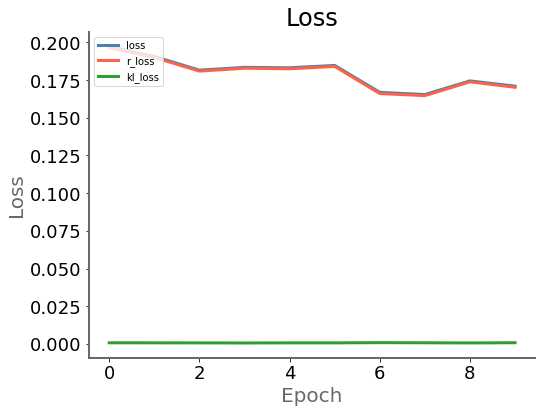

In [10]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

<br>**Original images :**

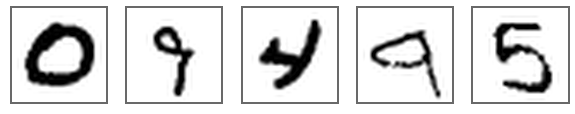

<br>**Encoded/decoded images**

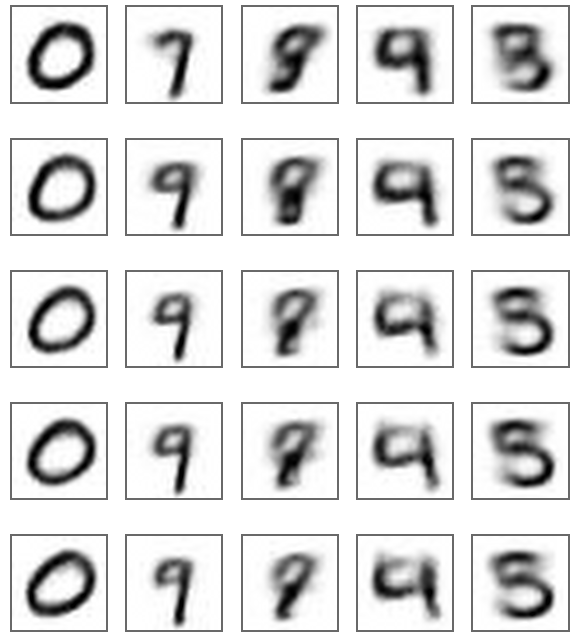

<br>**Original images :**

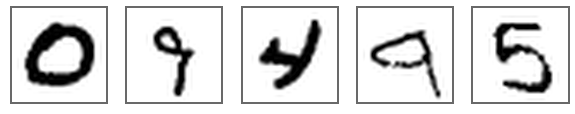

In [11]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-original')

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder) during training

<br>**Generated images from latent space**

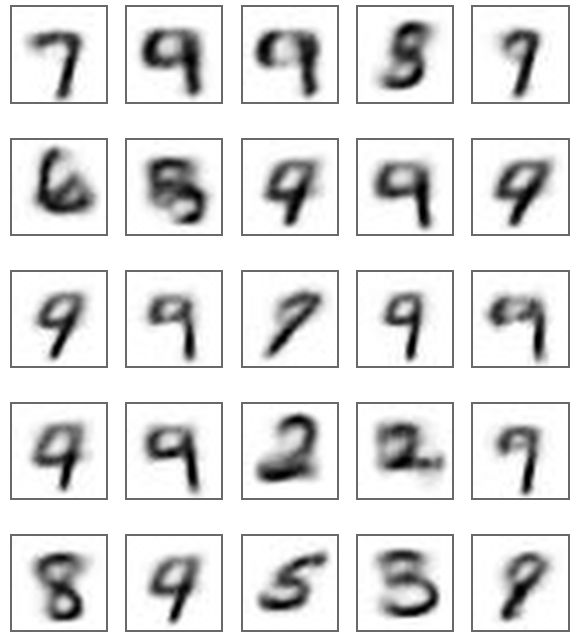

In [12]:
pwk.subtitle('Generated images from latent space')
pwk.plot_images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='04-encoded')

## Step 7 - Model evaluation

### 7.1 - Reload best model

In [13]:
vae=VAE()
vae.reload(f'{run_dir}/models/best_model')

Fidle VAE is ready :-)  loss_weights=[1, 1]
Reloaded.


### 7.2 - Image reconstruction

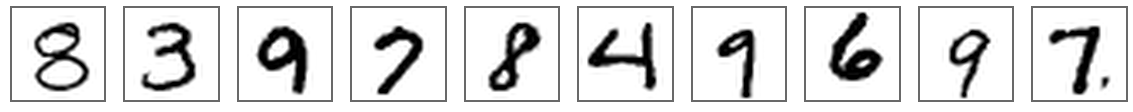

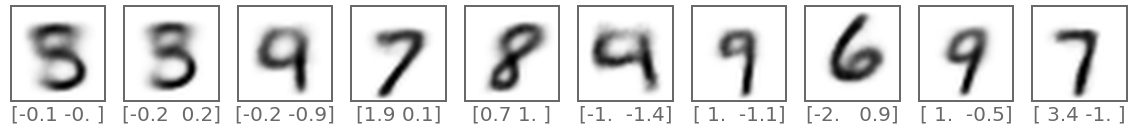

In [14]:
# ---- Select few images

x_show = pwk.pick_dataset(x_data, n=10)

# ---- Get latent points and reconstructed images

z_mean, z_var, z  = vae.encoder.predict(x_show)
x_reconst         = vae.decoder.predict(z)

# ---- Show it

labels=[ str(np.round(z[i],1)) for i in range(10) ]
pwk.plot_images(x_show,    None, indices='all', columns=10, x_size=2,y_size=2, save_as='05-original')
pwk.plot_images(x_reconst, labels  , indices='all', columns=10, x_size=2,y_size=2, save_as='06-reconstruct')


### 7.3 - Visualization of the latent space

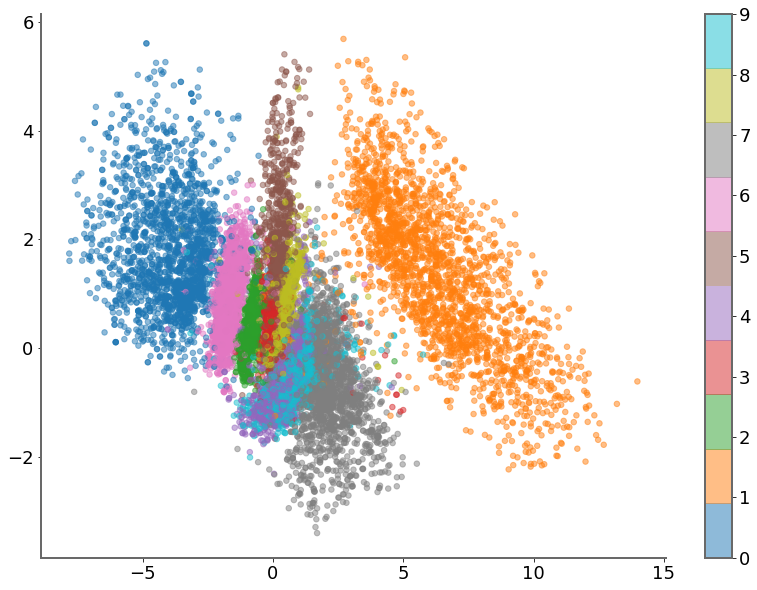

In [15]:
n_show = 20000

# ---- Select images

x_show, y_show = pwk.pick_dataset(x_data,y_data, n=n_show)

# ---- Get latent points

z_mean, z_var, z = vae.encoder.predict(x_show)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
pwk.save_fig('07-Latent-space')
plt.show()

### 7.4 - Generative latent space

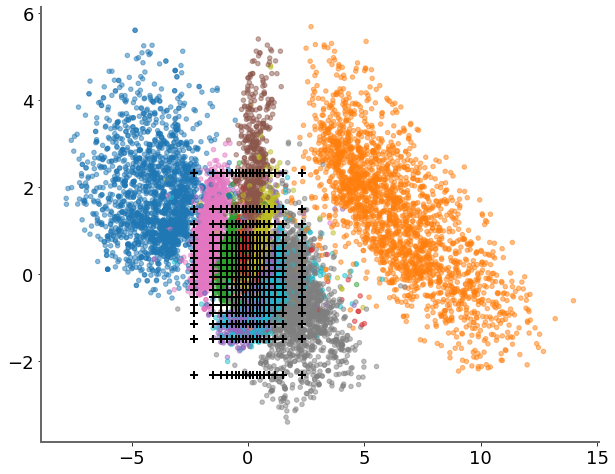

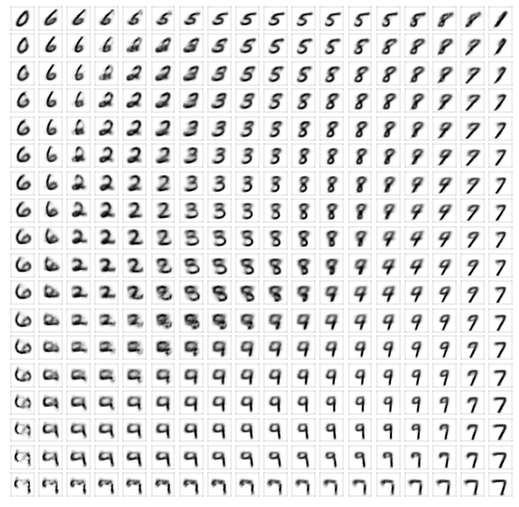

In [16]:
grid_size   = 18
grid_scale  = 1

# ---- Draw a ppf grid

grid=[]
for y in scipy.stats.norm.ppf(np.linspace(0.99, 0.01, grid_size),scale=grid_scale):
    for x in scipy.stats.norm.ppf(np.linspace(0.01, 0.99, grid_size),scale=grid_scale):
        grid.append( (x,y) )
grid=np.array(grid)

# ---- Draw latentspoints and grid

fig = plt.figure(figsize=(10, 8))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=20)
plt.scatter(grid[:, 0] , grid[:, 1], c = 'black', s=60, linewidth=2, marker='+', alpha=1)
pwk.save_fig('08-Latent-grid')
plt.show()

# ---- Plot grid corresponding images

x_reconst = vae.decoder.predict([grid])
pwk.plot_images(x_reconst, indices='all', columns=grid_size, x_size=0.5,y_size=0.5, y_padding=0,spines_alpha=0.1, save_as='09-Latent-morphing')



In [17]:
pwk.end()

End time is : Monday 22 March 2021, 14:43:01
Duration is : 00:01:49 896ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>